In [1]:
from bayes3d.dino import Dino
import bayes3d as b
import os
import torch
import numpy as np
import matplotlib
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torchvision.transforms as T
import bayes3d.ycb_loader
import bayes3d.o3d_viz
from tqdm import tqdm
import open3d as o3d


/home/nishadgothoskar/anaconda3/envs/bayes3d/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')
dino = dinov2_vitg14.to(device)  # Same issue with larger model
feat_dim = 1536 # vitg14


def get_embeddings(rgbd):
    img = b.get_rgb_image(rgbd.rgb).convert('RGB')
    patch_h, patch_w = np.array(img.size) // 14
    transform = T.Compose([
        T.GaussianBlur(9, sigma=(0.1, 2.0)),
        T.Resize((patch_h * 14, patch_w * 14)),
        T.CenterCrop((patch_h * 14, patch_w * 14)),
        T.ToTensor(),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ])
    tensor = transform(img)[:3].unsqueeze(0).to(device)
    with torch.no_grad():
        features_dict = dinov2_vitg14.forward_features(tensor)
        features = features_dict['x_norm_patchtokens'][0].reshape((patch_h, patch_w, feat_dim)).permute(2, 0, 1).unsqueeze(0)
    print(features.shape)
    img_feat_norm = torch.nn.functional.normalize(features, dim=1)
    output = jnp.array(img_feat_norm.cpu().detach().numpy())[0]
    del img_feat_norm
    del features
    del tensor
    del features_dict
    torch.cuda.empty_cache()
    return jnp.transpose(output, (1,2,0))

Using cache found in /home/nishadgothoskar/.cache/torch/hub/facebookresearch_dinov2_main


In [4]:
h = 1400
intrinsics = b.Intrinsics(
    height=h,
    width=h,
    fx=3300.0, fy=3300.0,
    cx=h/2.0, cy=h/2.0,
    near=0.001, far=6.0
)
scaled_down_intrinsics = b.camera.scale_camera_parameters(intrinsics, 1.0/14.0)


In [5]:
b.setup_renderer(scaled_down_intrinsics)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [6]:
viz = b.o3d_viz.O3DVis(intrinsics)

[Open3D INFO] EGL headless mode enabled.


In [7]:
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_paths = []
for idx in range(1,22):
    mesh_paths.append(os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply"))
SCALING_FACTOR = 1.0/1000.0

/home/nishadgothoskar/anaconda3/envs/bayes3d/lib/python3.8/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/home/nishadgothoskar/anaconda3/envs/bayes3d/lib/python3.8/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


torch.Size([1, 1536, 100, 100])


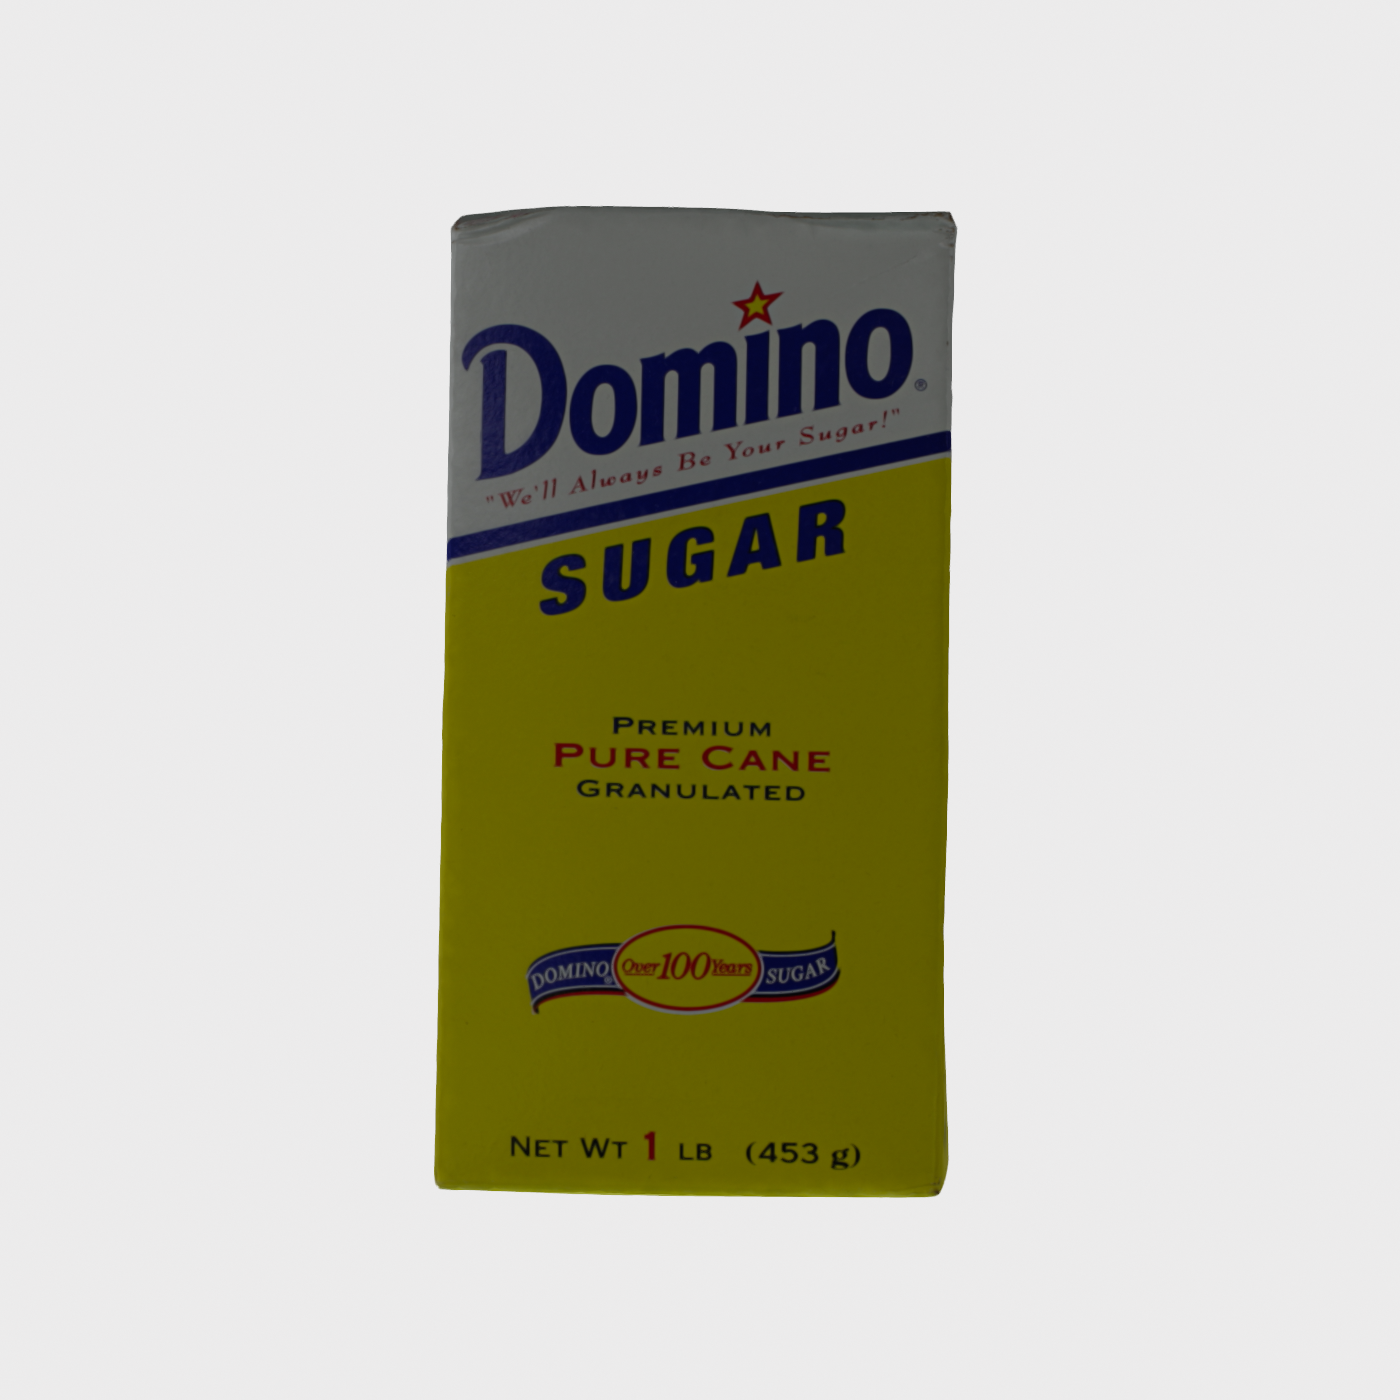

In [8]:
mesh_filename = mesh_paths[2]
angle = jnp.pi/2
mesh = o3d.io.read_triangle_model(mesh_filename)
pose = b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
    jnp.array([0.0, 0.6, 0.0]),
    jnp.array([0.0, 0.0, 0.0]),
    jnp.array([0.0, 0.0, 1.0]),
)) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle)

viz.clear()

mesh.meshes[0].mesh.scale(SCALING_FACTOR, np.array([0.0, 0.0, 0.0]))
mesh.meshes[0].mesh.transform(pose)
viz.render.scene.add_model(f"1", mesh)

training_rgbd = viz.capture_image(intrinsics, jnp.eye(4))
scaled_down_training_image = b.scale_rgbd(training_rgbd, 1.0/14.0) 

observed_embeddings = get_embeddings(training_rgbd)
b.get_rgb_image(training_rgbd.rgb)

In [10]:
foreground_mask = (jnp.inf != scaled_down_training_image.depth)
foreground_pixel_coordinates = jnp.transpose(jnp.vstack(jnp.where(foreground_mask)))

NUM_KEYPOINTS_TO_SELECT = 1000
subset = jax.random.choice(jax.random.PRNGKey(10),foreground_pixel_coordinates.shape[0], shape=(NUM_KEYPOINTS_TO_SELECT,), replace=False)

depth = jnp.array(scaled_down_training_image.depth)
depth = depth.at[depth == jnp.inf].set(0.0)
point_cloud_image = b.t3d.unproject_depth(depth, scaled_down_training_image.intrinsics)

keypoint_world_coordinates = point_cloud_image[foreground_pixel_coordinates[subset,0], foreground_pixel_coordinates[subset,1],:]
keypoint_coordinates = b.t3d.apply_transform(keypoint_world_coordinates, b.t3d.inverse_pose(pose))
keypoint_embeddings = observed_embeddings[foreground_pixel_coordinates[subset,0], foreground_pixel_coordinates[subset,1],:]

b.clear()
b.show_cloud("1", keypoint_coordinates)

torch.Size([1, 1536, 100, 100])


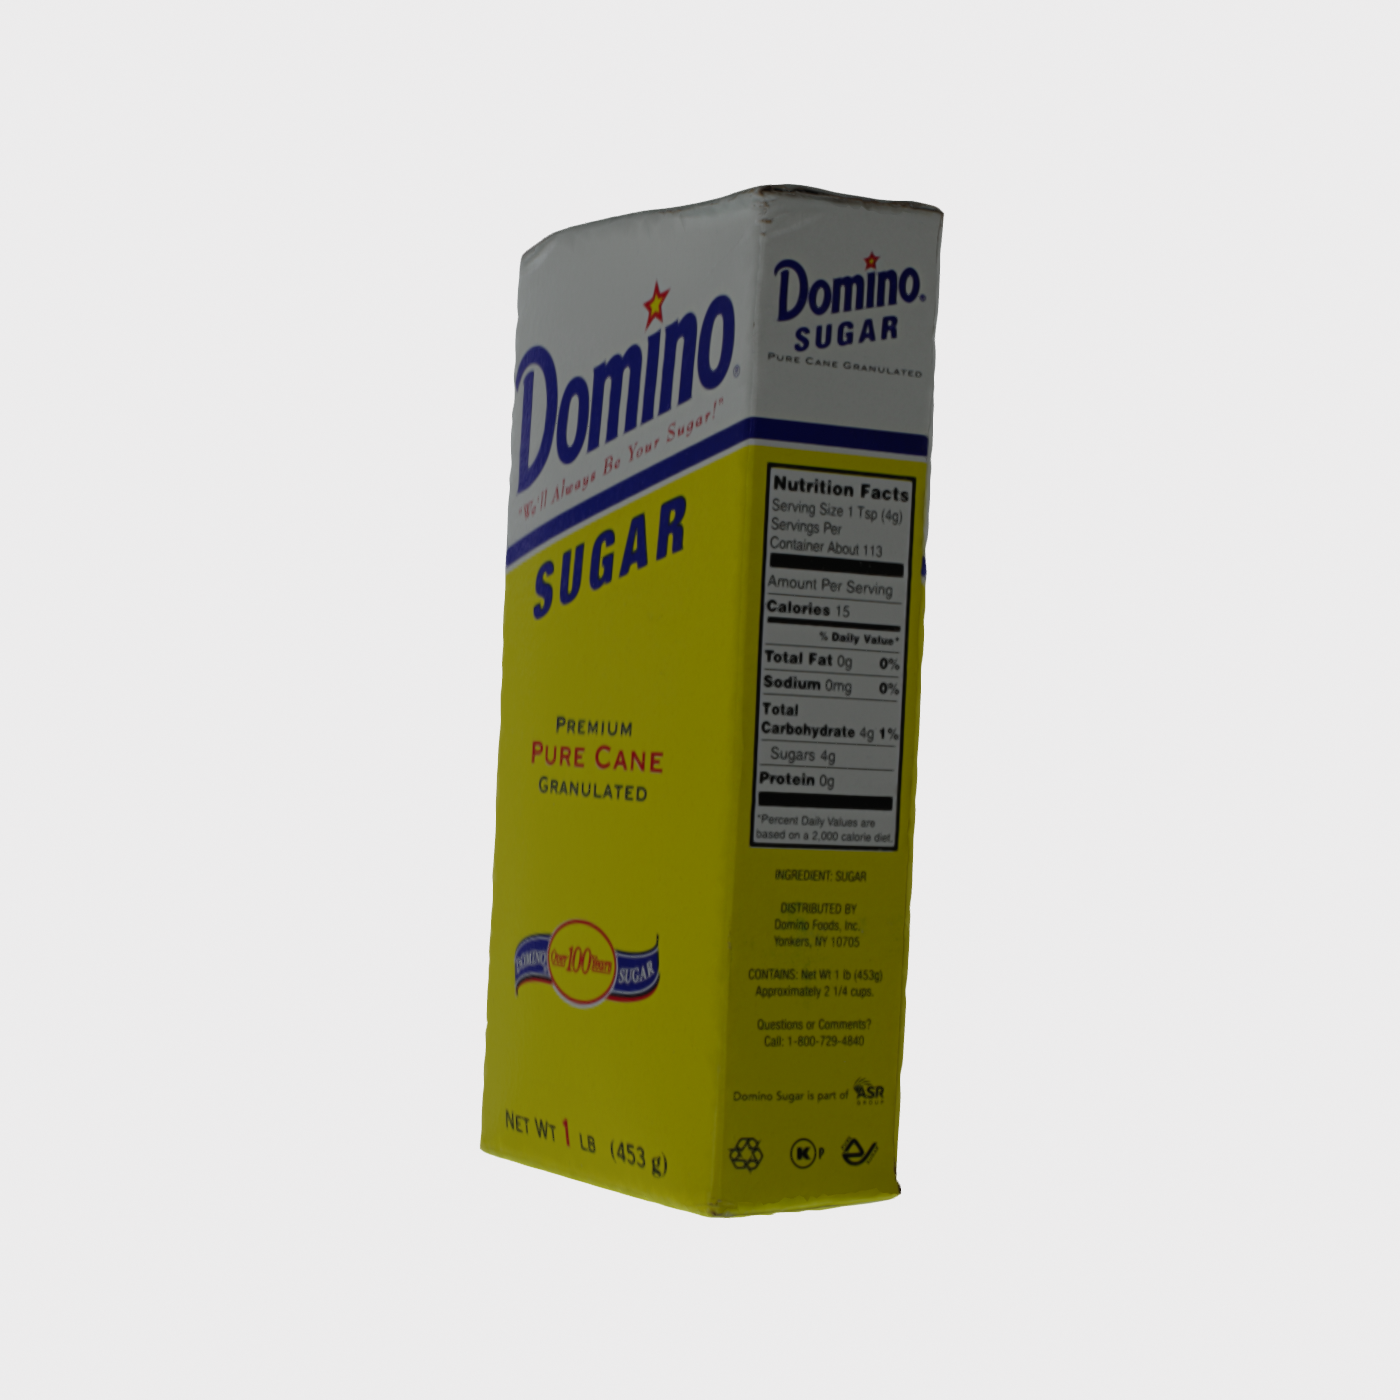

In [9]:
mesh_filename = mesh_paths[2]
angle = jnp.pi/2 - 1.0
mesh = o3d.io.read_triangle_model(mesh_filename)
pose = b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
    jnp.array([0.0, 0.6, 0.0]),
    jnp.array([0.0, 0.0, 0.0]),
    jnp.array([0.0, 0.0, 1.0]),
)) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle)

viz.clear()

mesh.meshes[0].mesh.scale(SCALING_FACTOR, np.array([0.0, 0.0, 0.0]))
mesh.meshes[0].mesh.transform(pose)
viz.render.scene.add_model(f"1", mesh)

training_rgbd = viz.capture_image(intrinsics, jnp.eye(4))
scaled_down_training_image = b.scale_rgbd(training_rgbd, 1.0/14.0) 

observed_embeddings = get_embeddings(training_rgbd)
b.get_rgb_image(training_rgbd.rgb)

In [11]:
b.setup_renderer(scaled_down_training_image.intrinsics)

FEngine (64 bits) created at 0x56427db45110 (threading is enabled)
EGL(1.5)
OpenGL(4.1)
Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [12]:
b.RENDERER.add_mesh_from_file(mesh_filename, scaling_factor=SCALING_FACTOR)

In [13]:
def render_embedding_image(pose, keypoint_coordinates, keypoint_embeddings):
    point_cloud_img = b.RENDERER.render_single_object(pose, jnp.int32(0))[:,:,:3]
    point_cloud_img_in_object_frame = b.t3d.apply_transform(point_cloud_img, b.t3d.inverse_pose(pose))

    distances_to_keypoints = (
        jnp.linalg.norm(point_cloud_img_in_object_frame[:, :,None,...] - keypoint_coordinates[None, None,:,...],
        axis=-1
    ))
    index_of_nearest_keypoint = distances_to_keypoints.argmin(2)
    distance_to_nearest_keypoints = distances_to_keypoints[jnp.arange(distances_to_keypoints.shape[0]), jnp.arange(distances_to_keypoints.shape[1]), 
                       index_of_nearest_keypoint]
    DISTANCE_THRESHOLD = 0.02
    valid_match_mask = (distance_to_nearest_keypoints < DISTANCE_THRESHOLD)[...,None]
        
    rendered_embeddings_image = keypoint_embeddings[index_of_nearest_keypoint] * valid_match_mask
    return rendered_embeddings_image

def score_pose(pose, keypoint_coordinates, keypoint_embeddings, observed_embeddings):
    rendrendered_embeddings_image = render_embedding_image(pose, keypoint_coordinates, keypoint_embeddings)
    dot_products = jnp.einsum("abi,abi->ab", rendrendered_embeddings_image, observed_embeddings)
    return dot_products.mean()

score_pose_jit = jax.jit(score_pose)

In [14]:
angle = jnp.pi/2 + 0.0
pose = b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
    jnp.array([0.0, 0.6, 0.0]),
    jnp.array([0.0, 0.0, 0.0]),
    jnp.array([0.0, 0.0, 1.0]),
)) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle)
score_pose_jit(pose, keypoint_coordinates, keypoint_embeddings, observed_embeddings)

Array(0.0265226, dtype=float32)

100%|████████████████████████████████████████| 300/300 [00:06<00:00, 45.59it/s]


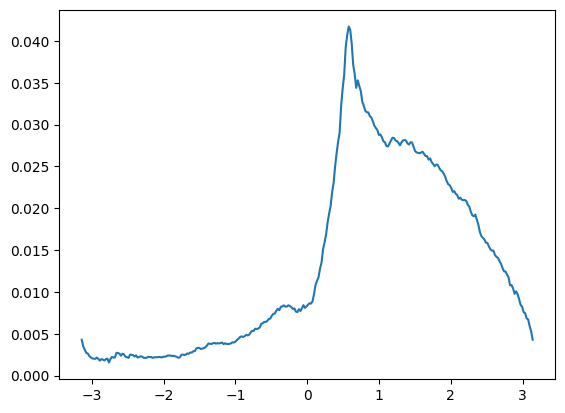

In [15]:
angles = jnp.linspace(-jnp.pi, jnp.pi, 300)
scores = []
for angle in tqdm(angles):
    pose = b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.6, 0.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle)
    scores.append(score_pose_jit(pose, keypoint_coordinates, keypoint_embeddings, observed_embeddings))
import matplotlib.pyplot as plt
plt.plot(angles, scores)

In [16]:
jnp.pi/2 - 1.0

0.5707963267948966

/home/nishadgothoskar/anaconda3/envs/bayes3d/lib/python3.8/site-packages/xformers/ops/unbind.py:46: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage_data_ptr = tensors[0].storage().data_ptr()
/home/nishadgothoskar/anaconda3/envs/bayes3d/lib/python3.8/site-packages/xformers/ops/unbind.py:48: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if x.storage().data_ptr() != storage_data_ptr:


torch.Size([1, 1536, 100, 100])


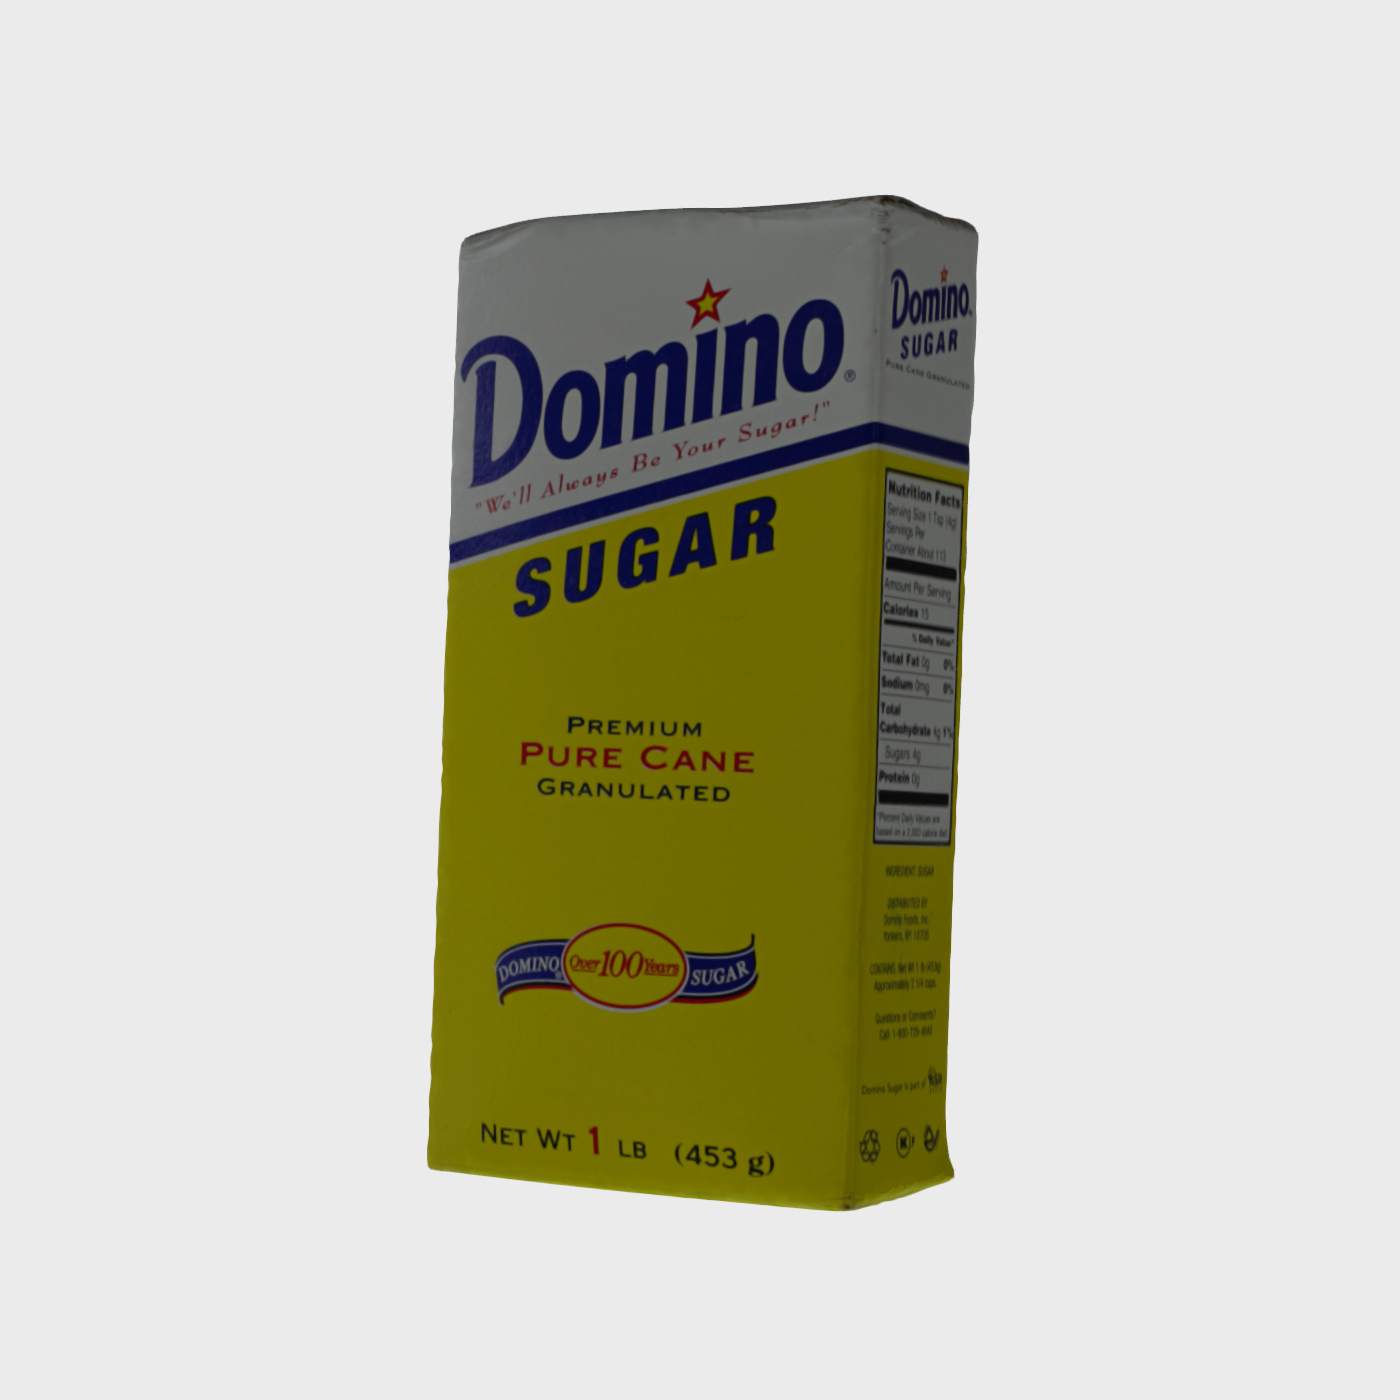

In [35]:
mesh_filename = mesh_paths[2]
angle = jnp.pi/2 - 0.5
mesh = o3d.io.read_triangle_model(mesh_filename)
pose = b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
    jnp.array([0.0, 0.6, 0.0]),
    jnp.array([0.0, 0.0, 0.0]),
    jnp.array([0.0, 0.0, 1.0]),
)) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle)

viz.clear()

mesh.meshes[0].mesh.scale(SCALING_FACTOR, np.array([0.0, 0.0, 0.0]))
mesh.meshes[0].mesh.transform(pose)
viz.render.scene.add_model(f"1", mesh)

training_rgbd = viz.capture_image(intrinsics, jnp.eye(4))
scaled_down_training_image = b.scale_rgbd(training_rgbd, 1.0/14.0) 

observed_embeddings = get_embeddings(training_rgbd)
b.get_rgb_image(training_rgbd.rgb)

In [37]:
observed_embeddings.shape

(100, 100, 1536)

In [38]:
angles = jnp.linspace(-jnp.pi, jnp.pi, 300)
scores = []
for angle in tqdm(angles):
    pose = b.t3d.inverse_pose(b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.6, 0.0]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )) @ b.t3d.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), angle)
    scores.append(score_pose_jit(pose, keypoint_coordinates, keypoint_embeddings, observed_embeddings))
import matplotlib.pyplot as plt
plt.plot(angles, scores)

2023-05-24 18:38:17.971524: E external/xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:790] failed to record completion event; therefore, failed to create inter-stream dependency
2023-05-24 18:38:17.971656: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:1182] failed to enqueue async memcpy from host to device: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered; GPU dst: 0x7fc3bbc00000; host src: 0x7fc3bbe00000; size: 4=0x4
2023-05-24 18:38:17.971690: E external/xla/xla/stream_executor/stream.cc:336] Error recording event in stream: Error recording CUDA event: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered; not marking stream as bad, as the Event object may be at fault. Monitor for further errors.
2023-05-24 18:38:17.971715: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:617] unable to add host callback: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered
2023-05-24 18:38:17.971911: E external/xla/xla/stream_exec

ValueError: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.func.launch' failed: Failed to launch CUDA kernel: fusion with block dimensions: 300x1x1 and grid dimensions: 1x1x1: CUDA_ERROR_ILLEGAL_ADDRESS: an illegal memory access was encountered.